In [95]:
import numpy as np
from ase.io import read
import matplotlib.pyplot as plt 
from ase import Atoms
from ase.build import graphene
from ase.visualize import view
from ase.build import graphene_nanoribbon
from ase.neighborlist import neighbor_list
from ase.build import make_supercell

import abtem

# Structure


Cell([26.84, 17.21658502723464, 50.0])


(<Figure size 1000x500 with 1 Axes>, <Axes: xlabel='y [Å]', ylabel='x [Å]'>)

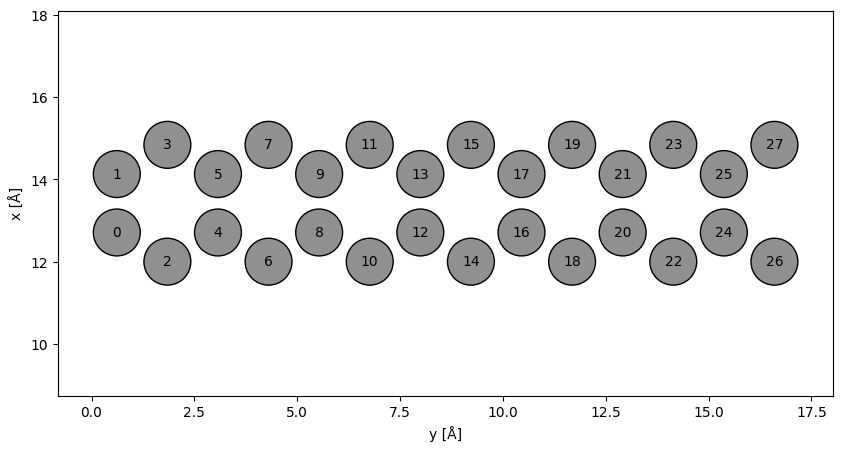

In [96]:
from functions import zgnr

Vpp_pi0=-2.7
Vpp_sigma0=0.48

# N = 6 # width
# L = 1 # length
# num_cells = 24

N = 2 # width
L = 1 # length
num_cells = 7

nL = 4
nR = 4

NR = zgnr(N,L)

NR.rotate(90, (1, 0, 0), rotate_cell=False)

NR.cell[1] = [0, NR.cell[2,2],0]
NR.cell[2] = [0,0,50.0]


# center in the cell
NR.center()

# sort atoms by x, then y (correct order)
xyz = NR.get_positions()
sorted_indices = np.lexsort((xyz[:, 0], xyz[:, 1]))  # no z sorting

NR = NR[sorted_indices]

# repeat
NR = NR.repeat((1,num_cells,1))
# atoms = atoms.repeat((1,5,1))


print(NR.cell)
#view(NR)
abtem.show_atoms(NR,plane='yx',numbering=True,merge = False,show_cell=False,figsize=(10,5))

# Top flake

<Popen: returncode: None args: ['/home/oia/miniconda3/envs/abtem311/bin/pyth...>

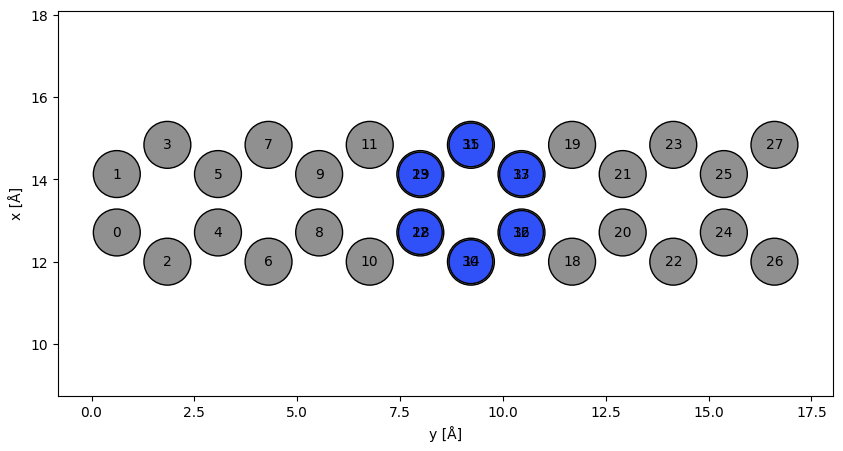

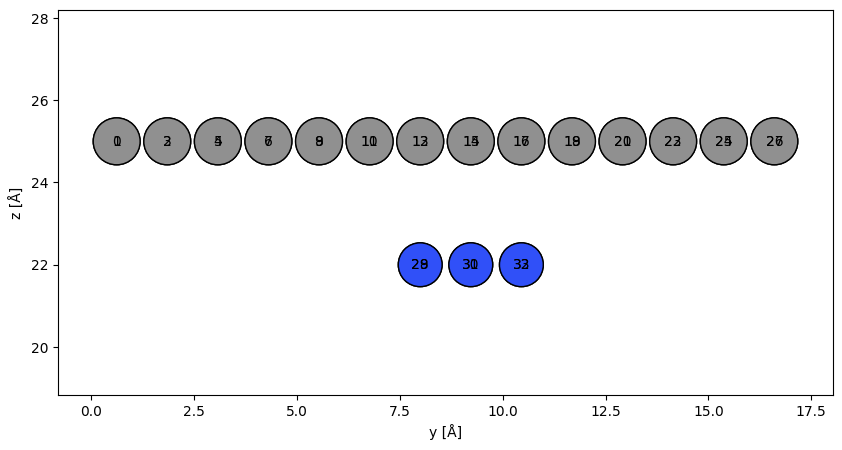

In [130]:
bottom = NR.copy()
top = NR.copy()

shiftxy = 0
shiftz = -3
shift = np.array([shiftxy, shiftxy, shiftz])
top.positions += shift

num_del = nL*3

del top[0:num_del]
del top[len(top)-num_del+2::]
# change symbol to Nitrogen for identification
top.symbols = 'N'
atoms = bottom + top

abtem.show_atoms(atoms,plane='yx',numbering=True,merge = False,show_cell=False,figsize=(10,5))
abtem.show_atoms(atoms,plane='yz',numbering=True,merge = False,show_cell=False,figsize=(10,5))

view(atoms)

# Hamilton

In [131]:
def slater_koster(
    atoms,
    cutoff=6,
    d0=1.42,
    d_gg=3.35,
    r0=0.45,
    Vpp_pi0=-2.7,
    Vpp_sigma0=0.48,
    onsite=0.0,
    carbon_only=True
):
    """
    Compute Slater-Koster tight-binding Hamiltonian for graphene structures.
    
    Parameters
    ----------
    atoms : ase.Atoms
        Atomic structure
    cutoff : float, optional
        Cutoff distance for interlayer hopping in Angstrom, default is 6
    d0 : float, optional
        In-plane C-C bond length in Angstrom, default is 1.42
    d_gg : float, optional
        Interlayer distance in Angstrom, default is 3.35
    r0 : float, optional
        Decay length in Angstrom, default is 0.45
    Vpp_pi0 : float, optional
        Pi-orbital hopping parameter in eV, default is -2.7
    Vpp_sigma0 : float, optional
        Sigma-orbital hopping parameter in eV, default is 0.48
    onsite : float, optional
        On-site energy in eV, default is 0.0
    carbon_only : bool, optional
        Whether to consider only carbon atoms, default is True
    
    Returns
    -------
    H : np.ndarray
        Total Hamiltonian matrix (H_TB + H_SK)
    H_TB : np.ndarray
        In-plane tight-binding Hamiltonian
    H_SK : np.ndarray
        Slater-Koster interlayer Hamiltonian
    H_pi : np.ndarray
        Pi-orbital contribution
    H_sigma : np.ndarray
        Sigma-orbital contribution
    """
    pos = atoms.positions
    N = len(atoms)

    H_TB = np.zeros((N, N))
    H_pi = np.zeros((N, N),)
    H_sigma = np.zeros((N, N))

    # onsite term (pi channel)
    for i in range(N):
        if not carbon_only and atoms[i].symbol == 'N':
            H_pi[i, i] = onsite #+ 1.5  # Nitrogen has higher onsite energy
        else:
            H_pi[i, i] = onsite

    # In plane hopping
    for i in range(N):
        ri = pos[i]
        z_i=pos[i][2]
        for j in range(i + 1, N):
            rj = pos[j]
            z_j=pos[j][2]
            dvec = rj - ri
            R = np.linalg.norm(dvec)
            # check if the two atoms lie on the same z plane
            if np.abs(z_i-z_j) < 0.1: 
                 # Make TB hamiltonian
                 dist = np.linalg.norm(ri -rj, axis=0)
                 if  R < 1.5 and R > 0.1:
                    hop = Vpp_pi0
                    # Scale hopping for N-C or N-N bonds when carbon_only=False
                    if not carbon_only and (atoms[i].symbol == 'N' or atoms[j].symbol == 'N'):
                        hop *= 0.7  # Weaker hopping for N-containing bonds
                    H_TB[i, j] = hop
                    H_TB[j, i] = hop
            else:
                # Make SK
                if R < cutoff and R > 1e-8:
    
                    # angle factors
                    cos_theta = dvec[2] / R
                    cos2 = cos_theta**2
                    sin2 = 1.0 - cos2
    
                    # distance dependent hoppings
                    Vpi = Vpp_pi0 * np.exp(-(R - d0) / r0)
                    Vsigma = Vpp_sigma0 * np.exp(-(R - d_gg) / r0)
    
                    # separated contributions
                    t_pi = Vpi * sin2
                    t_sigma = Vsigma * cos2
    
                    # fill matrices
                    H_pi[i, j] = t_pi
                    H_pi[j, i] = t_pi
    
                    H_sigma[i, j] = t_sigma
                    H_sigma[j, i] = t_sigma


    H_SK = H_pi + H_sigma
    H = H_TB + H_SK
    return H,H_TB,H_SK,H_pi,H_sigma


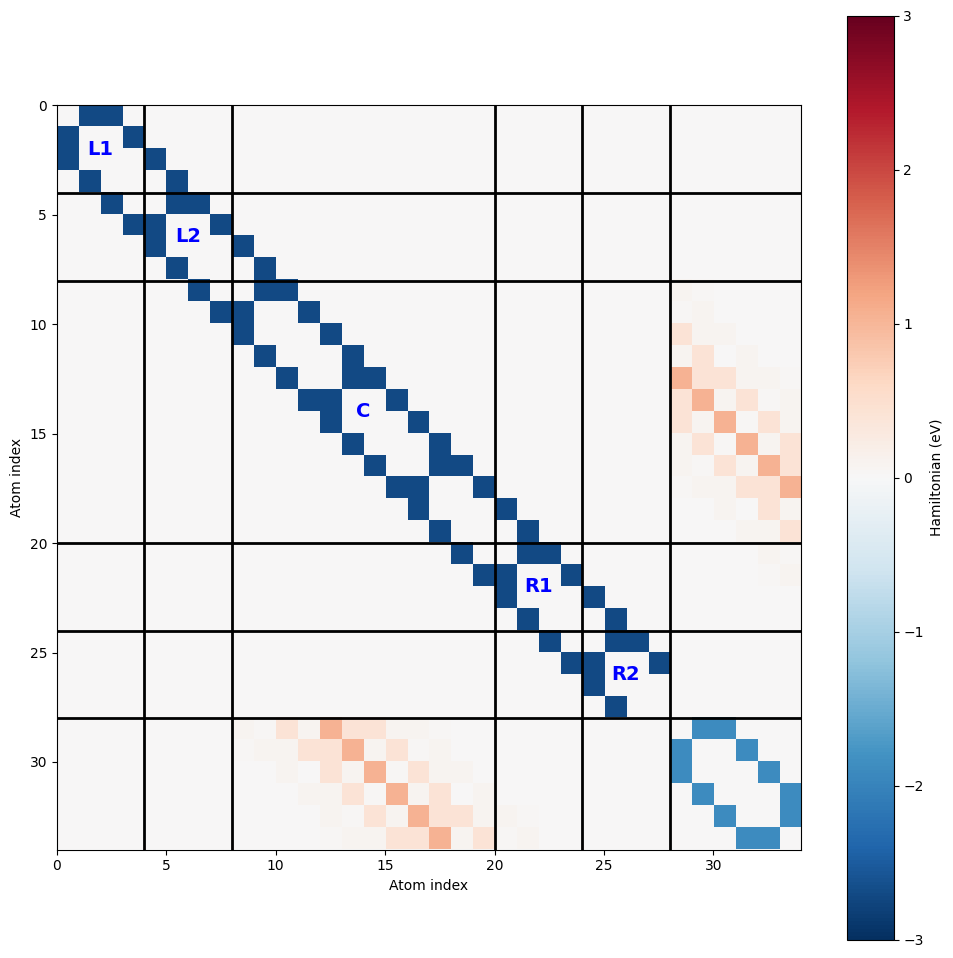

In [132]:
#from functions import slater_koster
H,H_TB,H_SK,_,_= slater_koster(atoms,carbon_only=False)

Hbig = H
nC = len(NR) - 2*nL - 2*nR

# Boundaries
b0 = 0
b1 = nL
b2 = 2*nL
b3 = 2*nL + nC
b4 = 2*nL + nC + nR
b5 = 2*nL + nC + 2*nR #Hbig.shape[0]

plt.figure(figsize=(12,12))
# Use imshow with extent to align indices properly
n = Hbig.shape[0]
plt.imshow(Hbig, extent=(0, n, n, 0), cmap='RdBu_r', vmin=-3, vmax=3)
plt.colorbar(label='Hamiltonian (eV)')

# Draw block boundaries
for b in [b1, b2, b3, b4,b5]:
    plt.axhline(b, color='k', linewidth=2)
    plt.axvline(b, color='k', linewidth=2)

# Add text labels
plt.text((b0+b1)/2, (b0+b1)/2, "L1", ha='center', va='center', color='b', fontsize=14, weight='bold')
plt.text((b1+b2)/2, (b1+b2)/2, "L2", ha='center', va='center', color='b', fontsize=14, weight='bold')
plt.text((b2+b3)/2, (b2+b3)/2, "C", ha='center', va='center', color='b', fontsize=14, weight='bold')
plt.text((b3+b4)/2, (b3+b4)/2, "R1", ha='center', va='center', color='b', fontsize=14, weight='bold')
plt.text((b4+b5)/2, (b4+b5)/2, "R2", ha='center', va='center', color='b', fontsize=14, weight='bold')

plt.xlabel('Atom index')
plt.ylabel('Atom index')
plt.show()


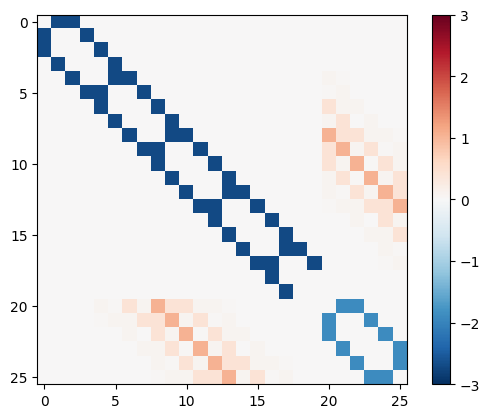

In [133]:
from functions import SplitHamMoy
HL,VL, HR, VR, HC, VLC, VRC, HD, VLD, VRD, HF =SplitHamMoy(H, nL, nR, nF = len(top))
plt.imshow(HD,  cmap='RdBu_r', vmin=-3, vmax=3)
plt.colorbar()

# Transmission

In [ ]:
from functions import get_surface_greens_function
def compute_transmission_caroli_v2(energy, eta,HL,VL, HR, VR, HC, VLC, VRC, HD, VLD, VRD,method=1 ):
    """
    Computes transmission T(E) based on the formulas:
    Sigma_L = V_LD.dag @ g_L @ V_LD
    Sigma_R = V_RD @ g_R @ V_RD.dag
    T(E) = Trace[Gamma_R @ G_D @ Gamma_L @ G_D_dag]
    """
    z = energy + 1j * eta

    # 1. Surface Green's Functions for leads
    gl_s,gl_b,sigmal_s,sigmal_b = get_surface_greens_function(HL, VL,z)
    gr_s,gr_b,sigmar_s,sigmar_b = get_surface_greens_function(HR, VR,z)

    if method == 2:

        # Infer sizes from blocks
        nL = HL.shape[0]
        nR = HR.shape[0]
        nC = HC.shape[0]
        dim = nL+nC+nR # of bottom device part
        

        nD = HD.shape[0]
        I = np.eye(nD, dtype=complex)

        h_eff = HD.astype(complex).copy()
        
        sigma_L = sigmal_s
        sigma_R = sigmar_s


        h_eff[0:nL, 0:nL] += sigma_L

        h_eff[nL + nC:dim, nL + nC:dim] += sigma_R #

        g = np.linalg.inv(z * I - h_eff)

        gamma_L = np.zeros((nD, nD), dtype=complex)
        gamma_R = np.zeros((nD, nD), dtype=complex)

        gamma_L[0:nL, 0:nL] = 1j * (sigma_L - sigma_L.T.conj())
        gamma_R[nL + nC:dim, nL + nC:dim] = 1j * (sigma_R - sigma_R.T.conj())

        g_C = g
        t_matrix = gamma_R @ g_C @ gamma_L @ g.T.conj()

        
    # 5. Transmission T(E) = Trace[Gamma_R @ G_D @ Gamma_L @ G_D_dag]
  
    transmission= np.trace(t_matrix).real
    return transmission, gl_s, gl_b, gr_s, gr_b, g_C,sigma_L,sigma_R

In [135]:
#from functions import compute_transmission_caroli

# Calculate spectrum
energies = np.linspace(-10.0, 10.0, 1000)
results_2 = [compute_transmission_caroli(E, 1e-5,HL,VL, HR, VR, HC, VLC, VRC, HD, VLD, VRD,method=2) for E in energies]

# Unpack each column of the results
transmission_2, gl_s_2, gl_b_2, gr_s_2, gr_b_2, g_d_2,sigma_l_2,sigma_r_2 = map(np.array, zip(*results_2))

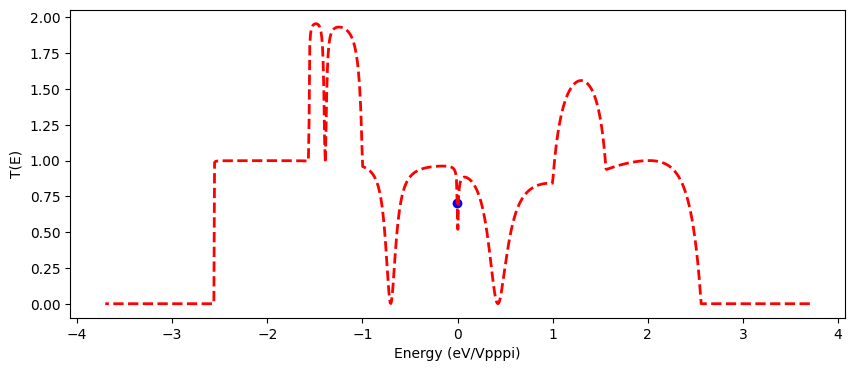

In [138]:
energy_idx = 500 

# --- Plotting ---
plt.figure(figsize=(10, 4))
plt.plot(energies/(-2.7), transmission_2, '--r', lw=2)
plt.scatter(energies[energy_idx]/(-2.7),transmission_2[energy_idx],color = 'b')
plt.xlabel("Energy (eV/Vpppi)")
plt.ylabel("T(E)")
plt.show()

In [139]:
bottom_idxs = range(nL,2*nL+nC+nR)
top_idxs = range(2*nL+nC+2*nR,len(H))

device_idxs = list(bottom_idxs) + list(top_idxs)

print(device_idxs)

[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 28, 29, 30, 31, 32, 33]


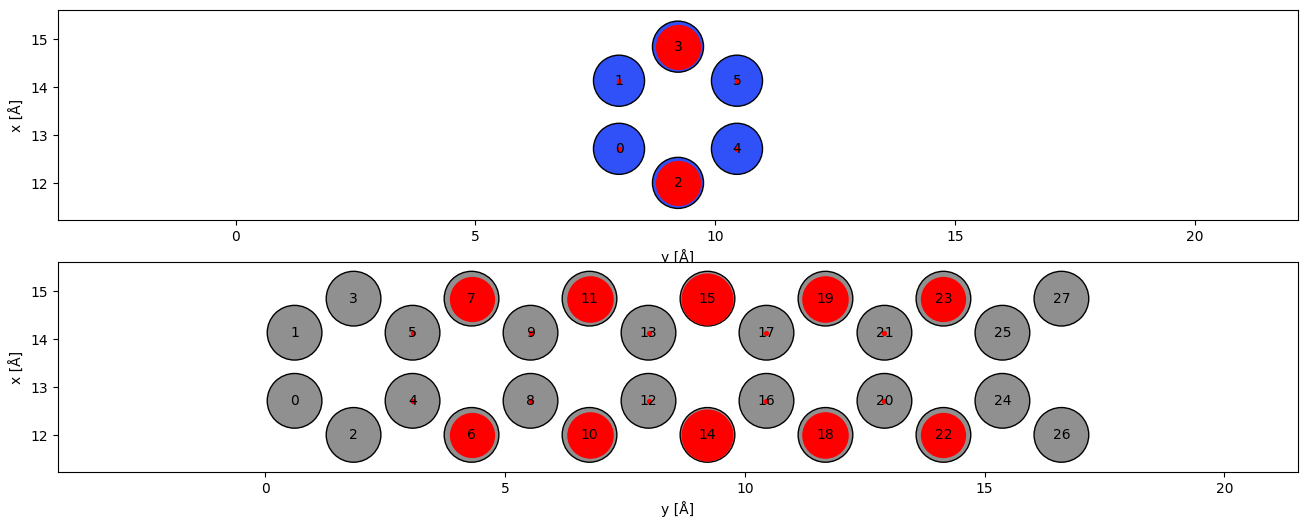

<Figure size 2000x800 with 0 Axes>

In [140]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharey=True, figsize=(16, 6))
abtem.show_atoms(top,plane='yx',numbering=True,merge = False,show_cell=False, figsize = (20,8),ax = ax1)

for i,idx in enumerate(top_idxs): 
    ax1.scatter(atoms.positions[idx,1],atoms.positions[idx,0],s=-1000*np.imag(np.diag(g_d_2[energy_idx]))[i],c='r')

plt.figure(figsize=(20, 8))
abtem.show_atoms(NR,plane='yx',numbering=True,merge = False,show_cell=False, figsize = (20,8),ax =ax2)

for i,idx in enumerate(bottom_idxs): 
    ax2.scatter(atoms.positions[idx,1],atoms.positions[idx,0],s=-1000*np.imag(np.diag(g_d_2[energy_idx]))[i],c='r')


In [105]:
import imageio.v2 as imageio
import tempfile
import os

# Create frames for gif
frames = []
energy_indices = range(100, 900, 10)  # sample every 10th index

for idx in energy_indices:
    # Layout: top row transmission; bottom two rows for top/bottom layers
    fig = plt.figure(figsize=(16, 12))
    gs = fig.add_gridspec(3, 1, height_ratios=[1, 1.2, 1.2])
    ax_trans = fig.add_subplot(gs[0, :])
    ax_top = fig.add_subplot(gs[1, :])
    ax_bottom = fig.add_subplot(gs[2, :], sharey=ax_top)
    
    # Top panel: Transmission with current energy marked
    ax_trans.plot(energies/(-2.7), transmission_2, 'k', lw=2)
    ax_trans.scatter(energies[idx]/(-2.7), transmission_2[idx], color='r', s=100, zorder=5)
    ax_trans.axvline(energies[idx]/(-2.7), color='r', ls='--', alpha=0.3)
    ax_trans.set_xlabel("Energy (eV/Vpppi)", fontsize=12)
    ax_trans.set_ylabel("T(E)", fontsize=12)
    ax_trans.set_title(f"Energy index: {idx}, E = {energies[idx]/(-2.7):.3f} eV/Vpppi", fontsize=14)
    ax_trans.grid(alpha=0.3)
    
    # Middle panel: Top layer with LDOS
    abtem.show_atoms(top, plane='yx', numbering=False, merge=False, 
                     show_cell=False, ax=ax_top)
    for i, atom_idx in enumerate(top_idxs):
        ldos_val = -np.imag(np.diag(g_d_2[idx]))[i]
        if ldos_val > 0:
            ax_top.scatter(atoms.positions[atom_idx, 1], atoms.positions[atom_idx, 0],
                          s=1000*ldos_val, c='red', alpha=0.7, 
                          edgecolors='darkred', linewidths=0.8, zorder=10)
    ax_top.set_title("Top Layer LDOS", fontsize=13)
    ax_top.set_ylabel("x position (Å)", fontsize=12)
    
    # Bottom panel: Bottom layer with LDOS
    abtem.show_atoms(NR, plane='yx', numbering=False, merge=False,
                     show_cell=False, ax=ax_bottom)
    for i, atom_idx in enumerate(bottom_idxs):
        ldos_val = -np.imag(np.diag(g_d_2[idx]))[i]
        if ldos_val > 0:
            ax_bottom.scatter(atoms.positions[atom_idx, 1], atoms.positions[atom_idx, 0],
                             s=1000*ldos_val, c='red', alpha=0.7,
                             edgecolors='darkred', linewidths=0.8, zorder=10)
    ax_bottom.set_title("Bottom Layer LDOS", fontsize=13)
    ax_bottom.set_xlabel("y position (Å)", fontsize=12)
    ax_bottom.set_ylabel("x position (Å)", fontsize=12)
    
    plt.tight_layout()
    
    # Save to temporary file and read back
    with tempfile.NamedTemporaryFile(suffix='.png', delete=False) as tmp:
        fig.savefig(tmp.name, dpi=110, bbox_inches='tight')
        tmp_path = tmp.name
    frames.append(imageio.imread(tmp_path))
    os.unlink(tmp_path)
    plt.close(fig)
    
    if idx % 100 == 0:
        print(f"Processing frame {idx}...")

# Save as gif
imageio.mimsave('ldos_animation_3.gif', frames, fps=10, loop=0)
print("Animation saved as ldos_animation.gif")

Processing frame 100...
Processing frame 200...
Processing frame 300...
Processing frame 400...
Processing frame 500...
Processing frame 600...
Processing frame 700...
Processing frame 800...
Animation saved as ldos_animation.gif
